# Geoinformatika 

#### Strojové učení v geoinformatice

### Zadání semestrální úlohy 

**Klasifikace Land Cover pomocí rozhodovacího stromu** 

**Cílem** této úlohy je vytvořit a generalizovat rozhodovací strom (Decision Tree, DT) pro klasifikaci land cover na základě daných vstupních dat. Vzhledem k povaze dat bude třeba řešit několik problémů, které ovlivňují výkonnost a interpretaci modelu.

*Popis dat:* 

Vstupní proměnné: Data obsahují různé environmentální a DPZ charakteristiky (např. vegetační indexy, spektrální pásma, nadmořskou výšku, vlhkost půdy aj.).

*Specifika dat*:
- Obsahují šum, což může negativně ovlivnit tvorbu rozhodovacích pravidel.
- Mezi třídami existují překryvy (např. podobnost spektrálních vlastností mezi dvěma typy vegetace), což snižuje přesnost klasifikace.
- Pro dosažení vysoké přesnosti může být vyžadována tvorba hlubokého stromu, který je však náchylný k přeučení na šum nebo irelevantní vzory.

*Cíle úlohy*:
* Naučit rozhodovací strom klasifikovat typy land cover:
* Třídy: les, voda, zemědělská půda, městská zástavba, mokřady.
* Generalizovat model: Minimalizovat přeučení stromu na šum a zlepšit jeho schopnost generalizace na nová, neviděná data. 

### Postup řešení

In [32]:
# Knihovny
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [33]:
# nastavte vlatní hodnotu seed
seed_no = 6

In [34]:
# Počet vzorků
n_samples = 100000

In [35]:
ndvi = np.random.uniform(0, 1, n_samples)
ndwi = np.random.uniform(0, 1, n_samples)
rgb = np.random.uniform(0, 255, (n_samples, 3))
altitude = np.random.uniform(0, 2000, n_samples)
noise = np.random.uniform(0, 1, n_samples)

In [36]:
# Definice třídy na základě překrývajících se pravidel
labels = []
for i in range(n_samples):
    if ndvi[i] > 0.6 and ndwi[i] < 0.3:
        labels.append('les' if np.random.rand() > 0.1 else 'město')  # Přidání šumu
    elif ndvi[i] < 0.3 and ndwi[i] > 0.6:
        labels.append('voda')
    elif rgb[i, 0] > 200:
        labels.append('město')
    else:
        labels.append('trávník')


In [37]:
# Náhodné zamíchání špatných štítků
labels = np.array(labels)
for i in range(int(n_samples * 0.1)):
    labels[np.random.randint(0, n_samples)] = np.random.choice(['les', 'voda', 'město', 'trávník'])


In [38]:
# Vytvoření datové sady
df = pd.DataFrame({
    'NDVI': ndvi,
    'NDWI': ndwi,
    'Red': rgb[:, 0],
    'Green': rgb[:, 1],
    'Blue': rgb[:, 2],
    'Altitude': altitude,
    'Noise': noise,
    'Label': labels
})

In [39]:
# NDVI .. Altitude jsou vstpní proměnné, X
# Label je kategorie Lansd Cover, y

df.head()

x=df.drop("Label", axis=1)
x=x.drop("Noise", axis=1)

y=df["Label"]

### Modelování

In [40]:
from sklearn import tree
from sklearn.model_selection import train_test_split

#výběr trénovacích dat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 166)

clf = tree.DecisionTreeClassifier(
    max_depth=7,            #maximální hloubka grafu
    min_samples_leaf=13,    #minimální počet vzorků, které musí být v každém listovém uzlu
    max_features=0.7,        #maximální procento proměnných braných do úvahy při každém větvení
    random_state=16
)

# Trénování modelu
clf.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=7, max_features=0.7, min_samples_leaf=13,
                       random_state=16)

### Hodnocení modelu

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(x_test)    #model predikuje třídu land coveru (y) na základě parametrů x pro testová data
print("Přesnost klasifikace:")
print(classification_report(y_test, y_pred))

print("Chybová matice:")
print(confusion_matrix(y_test, y_pred))

#Křížová validace - metrikou je zvoleno vážené f1 skóre
cv_scores = cross_val_score(clf, x, y, scoring="f1_weighted", cv=5)  # 5složková křížová validace
print("f1 skóre:", cv_scores)
print("Průměrné f1 skóre:", np.mean(cv_scores))


Přesnost klasifikace:
              precision    recall  f1-score   support

         les       0.85      0.83      0.84      3696
       město       0.93      0.83      0.88      5509
     trávník       0.93      0.98      0.96     16851
        voda       0.93      0.85      0.89      3944

    accuracy                           0.92     30000
   macro avg       0.91      0.87      0.89     30000
weighted avg       0.92      0.92      0.92     30000

Chybová matice:
[[ 3075   137   403    81]
 [  420  4599   410    80]
 [   69   108 16589    85]
 [   75   124   410  3335]]
f1 skóre: [0.91567449 0.9201     0.91424435 0.9171709  0.91903438]
Průměrné f1 skóre: 0.9172448230786776


### Experimenty pro generalizaci
Práce s parametry: max_features, max_depth a min_samples_leaf

In [42]:
#fce pro vizualizaci výsledků při odlišných parametrech
def vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations):
    plt.figure(figsize=(12, 6))
    plt.plot(parameter_combinations, f1_test_list, label="F1 Test", marker="o")
    plt.plot(parameter_combinations, f1_train_list, label="F1 Train", marker="x")
    plt.xticks(rotation=90, fontsize=7)
    plt.xlabel("kombinace parametrů")
    plt.ylabel("F1 skóre")
    plt.title("Vývoj F1 pro různé kombinace parametrů")
    plt.legend()
    plt.grid()
    plt.show()

max_features: 0.7, max_depth: 1, min_samples_leaf: 13
F1_train: 0.610, F1_test: 0.609
max_features: 0.7, max_depth: 2, min_samples_leaf: 13
F1_train: 0.610, F1_test: 0.609
max_features: 0.7, max_depth: 3, min_samples_leaf: 13
F1_train: 0.729, F1_test: 0.732
max_features: 0.7, max_depth: 4, min_samples_leaf: 13
F1_train: 0.872, F1_test: 0.875
max_features: 0.7, max_depth: 5, min_samples_leaf: 13
F1_train: 0.814, F1_test: 0.808
max_features: 0.7, max_depth: 6, min_samples_leaf: 13
F1_train: 0.916, F1_test: 0.917
max_features: 0.7, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 8, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 9, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 10, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 11, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.917
max_features: 0.7, max_depth: 12, min_samples_leaf: 

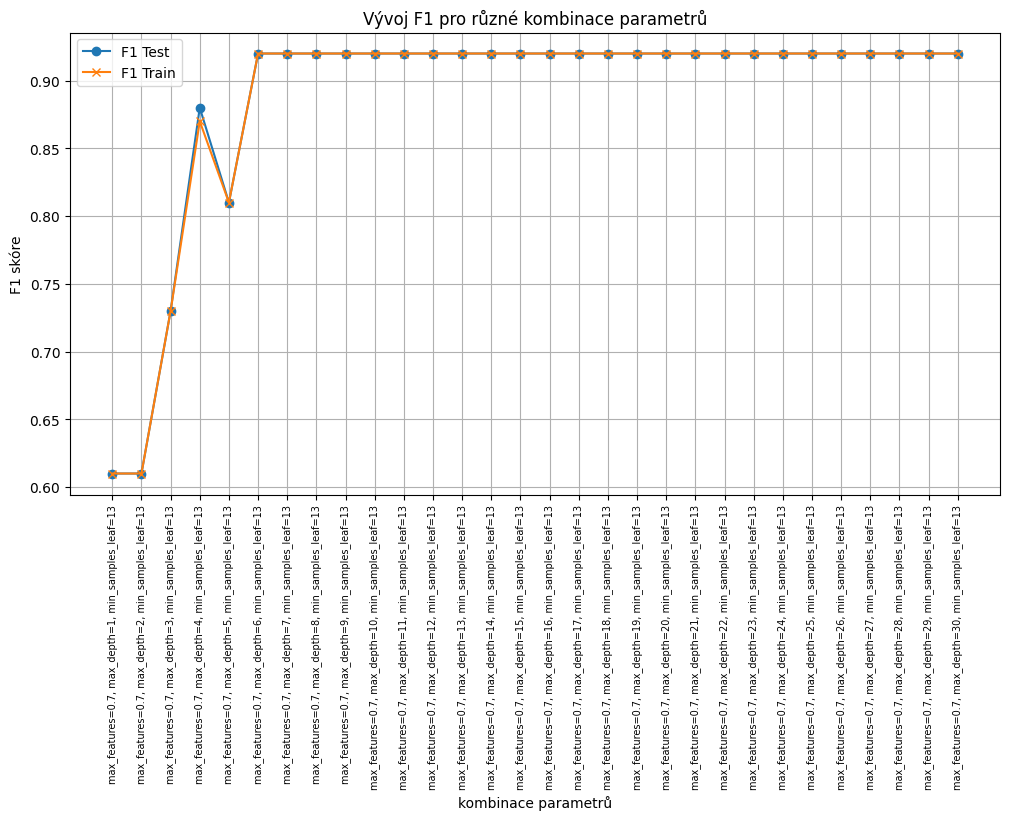

max_features: 0.7, max_depth: 7, min_samples_leaf: 1
F1_train: 0.918, F1_test: 0.918
max_features: 0.7, max_depth: 7, min_samples_leaf: 2
F1_train: 0.892, F1_test: 0.893
max_features: 0.7, max_depth: 7, min_samples_leaf: 3
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 7, min_samples_leaf: 4
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 7, min_samples_leaf: 5
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 7, min_samples_leaf: 6
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 7, min_samples_leaf: 7
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 7, min_samples_leaf: 8
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 7, min_samples_leaf: 9
F1_train: 0.917, F1_test: 0.919
max_features: 0.7, max_depth: 7, min_samples_leaf: 10
F1_train: 0.917, F1_test: 0.918
max_features: 0.7, max_depth: 7, min_samples_leaf: 11
F1_train: 0.916, F1_test: 0.917
max_features: 0.7, max_depth: 7, min_samples_leaf: 12
F1_train:

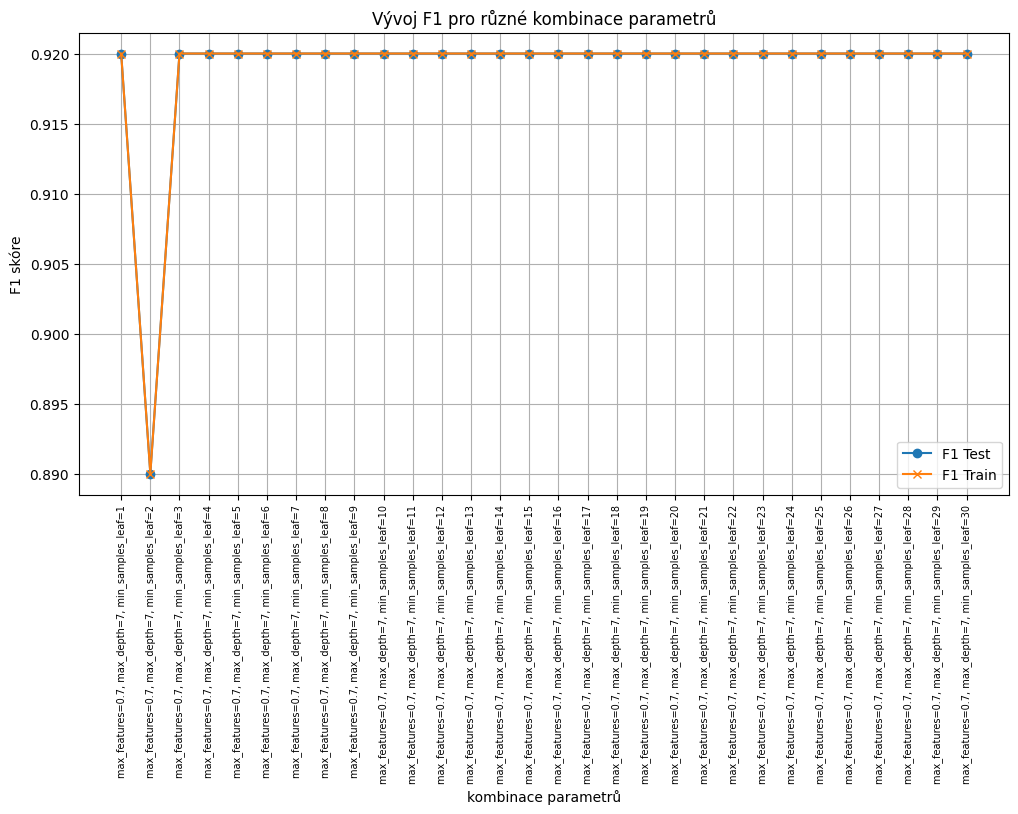

max_features: 0.1, max_depth: 7, min_samples_leaf: 13
F1_train: 0.635, F1_test: 0.632
max_features: 0.2, max_depth: 7, min_samples_leaf: 13
F1_train: 0.635, F1_test: 0.632
max_features: 0.30000000000000004, max_depth: 7, min_samples_leaf: 13
F1_train: 0.635, F1_test: 0.632
max_features: 0.4, max_depth: 7, min_samples_leaf: 13
F1_train: 0.908, F1_test: 0.908
max_features: 0.5, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918
max_features: 0.6, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918
max_features: 0.7000000000000001, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.919
max_features: 0.8, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.919
max_features: 0.9, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918
max_features: 1.0, max_depth: 7, min_samples_leaf: 13
F1_train: 0.917, F1_test: 0.918


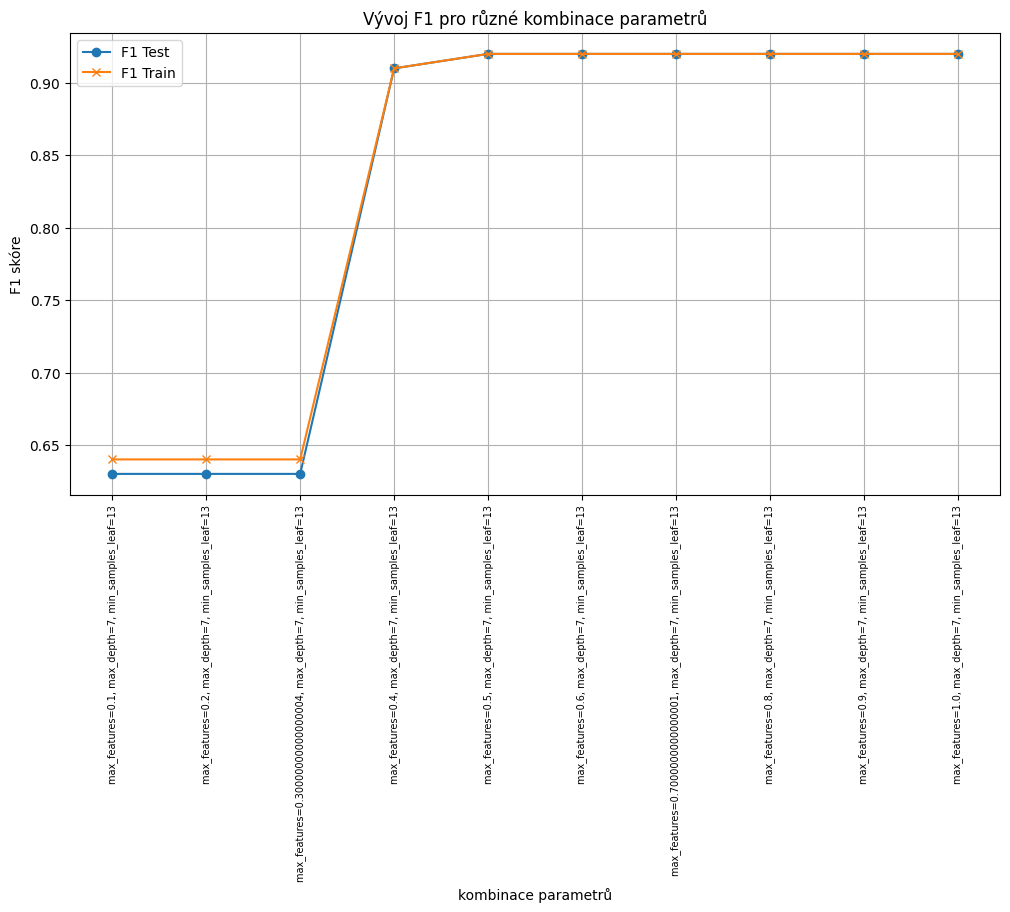

In [43]:
from sklearn.metrics import f1_score

#výchozí fixní hodnoty parametrů, v násldujících for cyklech budeme vždy měnit jeden z nich a sledovat jeho vliv na přesnost modelu
fixed_max_depth = 7
fixed_min_samples_leaf = 13
fixed_max_features = 0.7

#tvorba seznamů hodnot pparametrů přes které budeme iterovat
max_depth_values = range(1,31)
min_samples_leaf_values = range(1,31)
max_features_values = np.arange(0.1, 1.1, 0.1).tolist()

#seznamy pro ukládání výsledků
f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny max_depth
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(
        max_features=fixed_max_features,
        max_depth=max_depth,
        min_samples_leaf=fixed_min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={fixed_max_features}, max_depth={max_depth}, min_samples_leaf={fixed_min_samples_leaf}")

    print(f"max_features: {fixed_max_features}, max_depth: {max_depth}, min_samples_leaf: {fixed_min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny  min_samples_leaf
for min_samples_leaf in min_samples_leaf_values:
    clf = tree.DecisionTreeClassifier(
        max_features=fixed_max_features,
        max_depth=fixed_max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={fixed_max_features}, max_depth={fixed_max_depth}, min_samples_leaf={min_samples_leaf}")

    print(f"max_features: {fixed_max_features}, max_depth: {fixed_max_depth}, min_samples_leaf: {min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny max_features
for max_features in max_features_values:
    clf = tree.DecisionTreeClassifier(
        max_features=max_features,
        max_depth=fixed_max_depth,
        min_samples_leaf=fixed_min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={max_features}, max_depth={fixed_max_depth}, min_samples_leaf={fixed_min_samples_leaf}")

    print(f"max_features: {max_features}, max_depth: {fixed_max_depth}, min_samples_leaf: {fixed_min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

### Výstup úlohy

1. Naučený model rozhodovacího stromu schopný klasifikovat typy land cover s vyváženým poměrem přesnosti a generalizace.
2. Zpráva, která obsahuje:
    - Analýzu generalizace modelu. Citlivost parametrů modelu. 
    - Hodnocení modelu na testovacích datech (přesnost).
    - Diskuzi o problémech s přeučením a šumem a jejich řešeních.

### Zpráva k úloze

- jaký parametr byl nejcitlivější
- hodnocení na testovacích datech - vychází f1 rovno 1 u trénovacích i testovacích :o - divné
- přeučení a šum

In [44]:
pass 

Výsledek Vašeho řešení zašlete do 23.1.2025 na email: lukas.brodsky@natur.cuni.cz 